In [6]:
import yfinance as yf
df=yf.download('NVDA','2021-01-01','2021-12-31')
df_p=df[['Adj Close']]
df_p.head(3)

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2021-01-04,130.875916
2021-01-05,133.782684
2021-01-06,125.895790


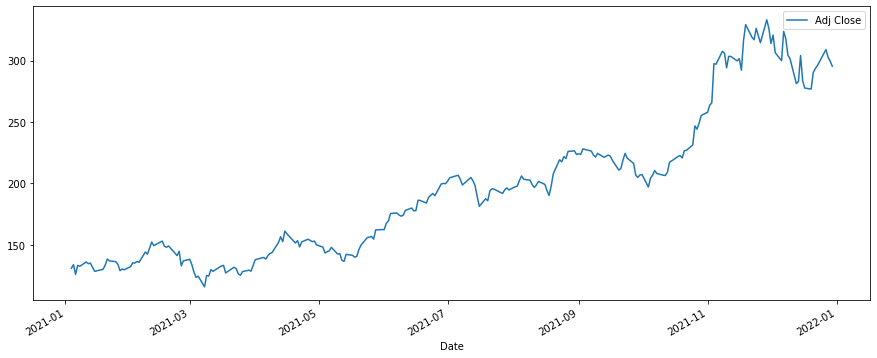

In [9]:
df_p.plot(figsize=(15,6))
plt.show()

In [10]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [11]:
adftest=adfuller(df_p['Adj Close'])
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -0.457262
ADF p-value: 0.900090


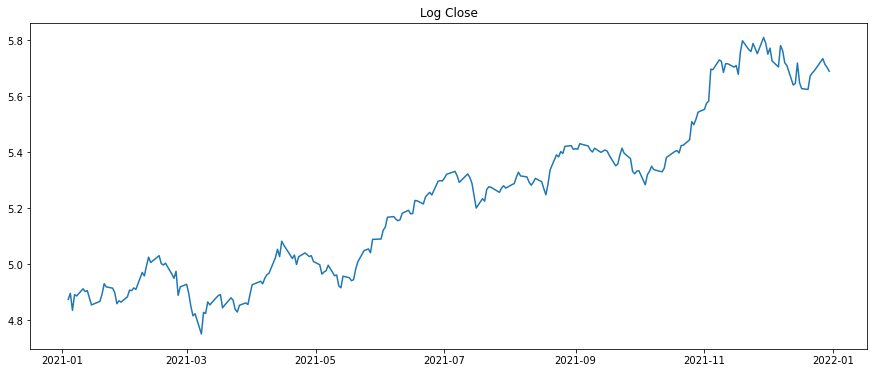

In [12]:
df_log=pd.DataFrame(np.log(df_p['Adj Close']),index=df_p.index)
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.title('Log Close')
plt.show()

In [14]:
adftest=adfuller(df_log['Adj Close'])
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -0.438769
ADF p-value: 0.903422


/tmp/ipykernel_457949/2979046514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['Returns']=df_p['Adj Close']-df_p['Adj Close'].shift(1)


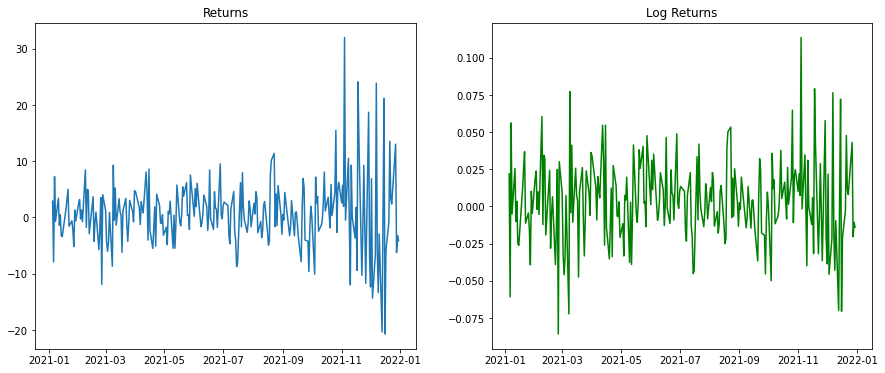

In [16]:
df_p['Returns']=df_p['Adj Close']-df_p['Adj Close'].shift(1)
df_log['Log_Returns']=df_log['Adj Close']-df_log['Adj Close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df_p['Returns'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df_log['Log_Returns'],'g-')
plt.title('Log Returns')
plt.show()

In [17]:
adftest_ret=adfuller(df_p['Returns'].dropna())
print('Returns ADF Statistic: %f' % adftest_ret[0])
print('Returns ADF p-value: %f' % adftest_ret[1])
adftest_lret=adfuller(df_log['Log_Returns'].dropna())
print('Log-Returns ADF Statistic: %f' % adftest_lret[0])
print('Log-Returns ADF p-value: %f' % adftest_lret[1])

Returns ADF Statistic: -5.043757
Returns ADF p-value: 0.000018
Log-Returns ADF Statistic: -17.167908
Log-Returns ADF p-value: 0.000000


In [ ]:
#Fractional differentiation
#https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing/notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

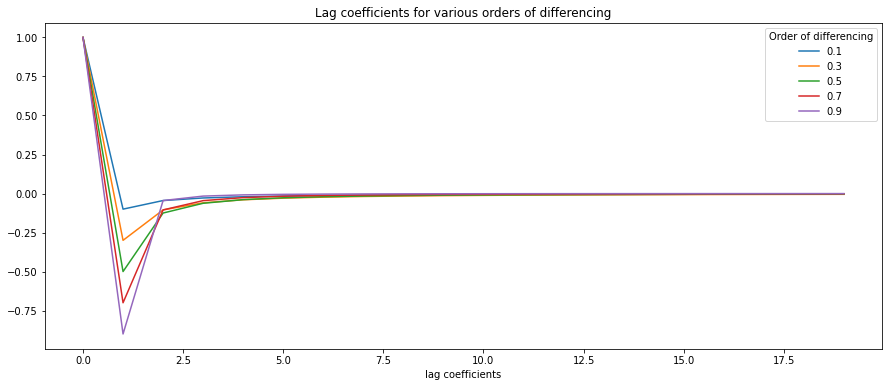

In [8]:
plotWeights([0.1,0.9],20,5)

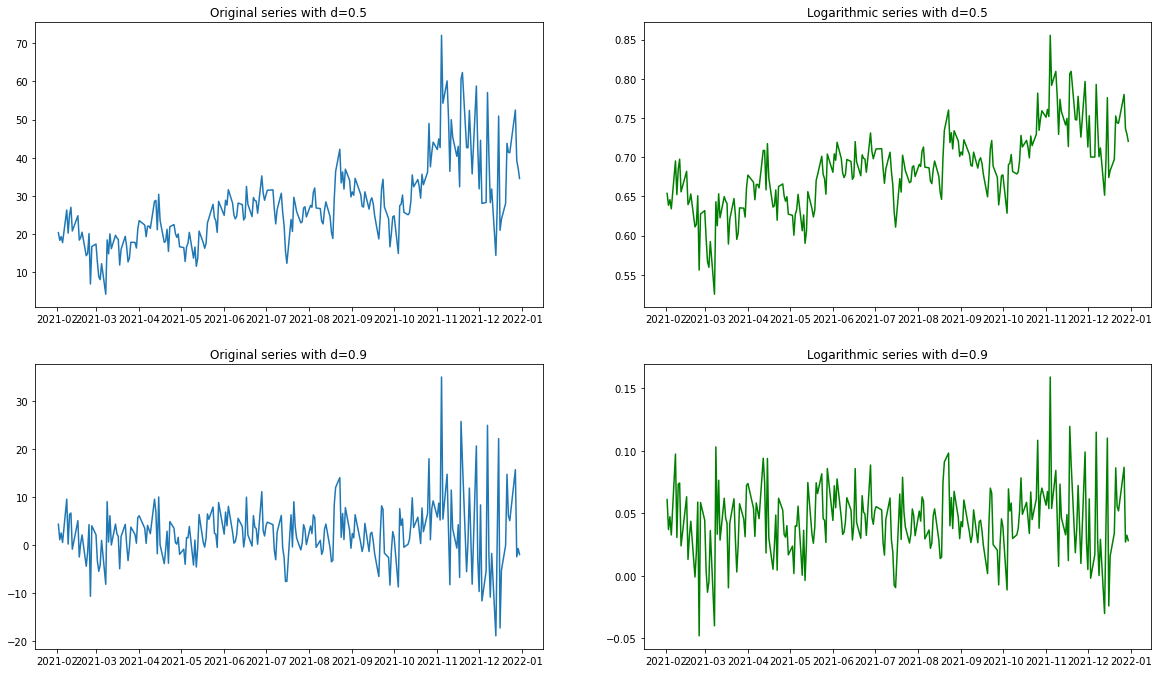

In [20]:
differences=[0.5,0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(20,10))
for i in range(0,len(differences)):
    axs[i,0].plot(ts_differencing(df_p['Adj Close'],differences[i],20))
    axs[i,0].set_title('Original series with d='+str(differences[i]))
    axs[i,1].plot(ts_differencing(df_log['Adj Close'],differences[i],20),'g-')
    axs[i,1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01)

In [21]:
def cutoff_find(order,cutoff,start_lags): 
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags

In [22]:
def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

In [24]:
possible_d=np.divide(range(1,100),100)
tau=1e-3
original_adf_stat_holder=[None]*len(possible_d)
log_adf_stat_holder=[None]*len(possible_d)

for i in range(len(possible_d)):
    original_adf_stat_holder[i]=adfuller(
        ts_differencing_tau(df_p['Adj Close'],possible_d[i],tau))[1]
    log_adf_stat_holder[i]=adfuller(
        ts_differencing_tau(df_log['Adj Close'],possible_d[i],tau))[1]

Text(0.5, 1.0, 'ADF P-value by differencing order in the logarithmic series')

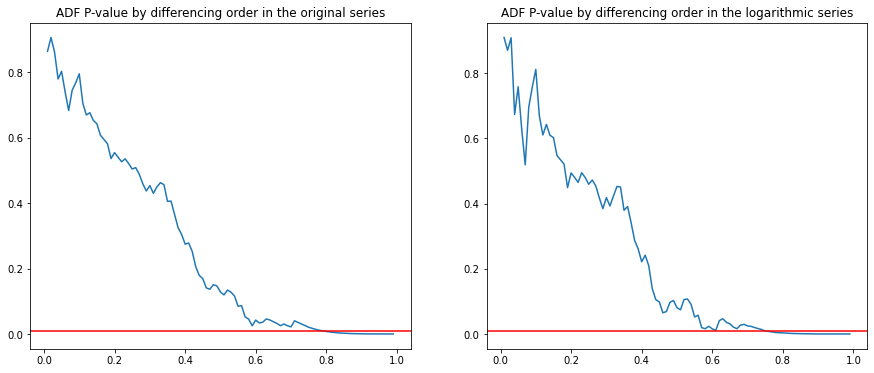

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(possible_d,original_adf_stat_holder)
axs[0].axhline(y=0.01,color='r')
axs[0].set_title('ADF P-value by differencing order in the original series')
axs[1].plot(possible_d,log_adf_stat_holder)
axs[1].axhline(y=0.01,color='r')
axs[1].set_title('ADF P-value by differencing order in the logarithmic series')